In [1]:
from __future__ import annotations

import custoch as cs
from custoch.euler import EulerPath
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math

# Pre requirements:
* ##### Python 3.10
* ##### Installed and configured numba with CUDA
* ##### Installed requirements using: `python -m pip install -r requirements.txt`

## General Configuration

In [2]:
dim = 4         # dimension of the process
wiener_dim = 5  # dimension of the Wiener process
N = 1000        # number of points in the grid
t_0 = 0.        # Start of the time interval
T = 1.          # end of the time interval
precision = cs.Precisions.float64   # precision, one of float16, float32,float64

## Case 1. Trajectory visualization ot the fallowing process
# $\mathrm{d}X_t=\mu(t,X_t)\mathrm{d}t + \sigma(t, X_t)\mathrm{d}W_t$
### User need to implement $\mu$ and $\sigma$ function on your own, see `drift_kernel` and `diffusion_kernel` for example.
#### In `drift_kernel` the argument `out` is placeholder for result and has shape: (`dim`, 1)
#### In `diffusion_kernel` the argument `out` is placeholder for result and has shape: (`dim`, `wiener_dim`)

In [3]:
start_point = np.array([[1.] for _ in range(dim)])  # initial point of the process
result = np.empty(shape=(dim, N))                   # empty array for the results

In [4]:
@cuda.jit(device=True)
def drift_kernel(t, x, out):                # mu function
    for i in range(x.shape[0]):
        out[i, 0] = i * 0.4 * x[i, 0]


@cuda.jit(device=True)
def diffusion_kernel(t, x, out):            # sigma function
    for i in range(x.shape[0]):
        for j in range(wiener_dim):
            out[i, j] = (-1)**(i + j) * 0.04 * (i + j + 1) * x[i, 0]

### Wrapping device function in to `KernelManager` processing call and copy data between host and device

In [5]:
kernel = cs.KernelManager(
    EulerPath(
        drift_kernel, diffusion_kernel,
        wiener_dim, dim,
        precision=cs.Precisions.float64,
        t_0=t_0, T=T, N=N
    ).get_kernel(),
    is_device=True,
    is_random=True,
    n_args=3
)

In [6]:
kernel[1, 1](start_point, result)

c:\users\marcin\pycharmprojects\custoch\venv\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


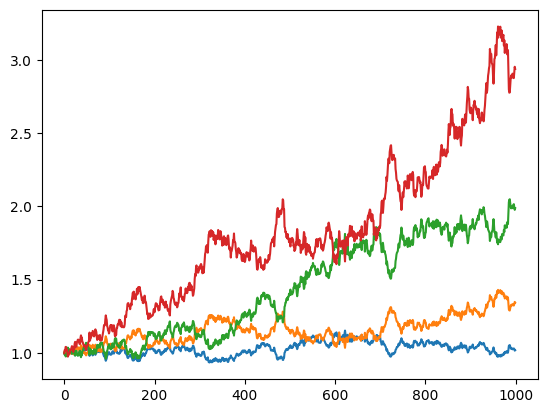

In [7]:
plt.plot(result.T)
plt.show()

## Weak approximation example
#### Configuration:

In [8]:
@cuda.jit(device=True)
def drift_kernel(t, x, out):
    for i in range(x.shape[0]):
        out[i, 0] = 0.4**i * math.cos(x[i, 0]) + i * t * 4


@cuda.jit(device=True)
def diffusion_kernel(t, x, out):
    for i in range(x.shape[0]):
        for j in range(wiener_dim):
            out[i, j] = (-1)**(i + j) * 0.4 * (j + 1) * math.sin(x[i, 0] - 3) / math.sqrt(1 + t)

In [9]:
dim = 5
wiener_dim = 1
N = 1000
t_0 = 0.
T = 1.
precision = cs.Precisions.float64

threads, blocks = 256, 128
K = threads * blocks        # number of trajectories

start_point = np.array([[1.] for _ in range(dim)])
result = np.empty(shape=(dim, K))

## sub-package `express` will contain very high level methods

In [10]:
from custoch.express.weak_appro import WeakApprox

In [11]:
kernel = WeakApprox(
    drift_kernel, diffusion_kernel,
    wiener_dim, dim,
    precision=cs.Precisions.float64,
    t_0=t_0, T=T, N=N, K=K
).get_wrapped_kernel()

In [12]:
kernel[blocks, threads](start_point, result)

## visualization of the results

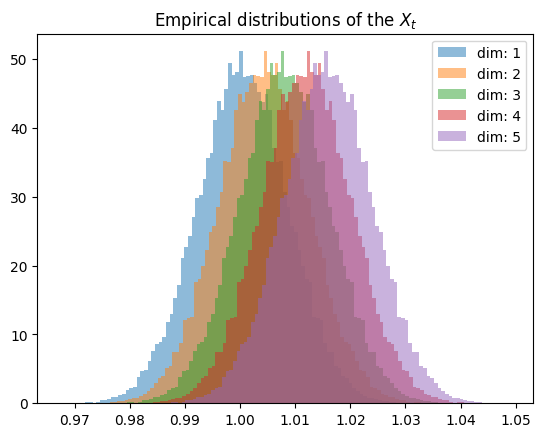

In [13]:
for i in range(result.shape[0]):
    plt.hist(result[i], bins=100, alpha=0.5, label=f'dim: {i + 1}', density=True)
plt.title('Empirical distributions of the $X_t$')
plt.legend()
plt.show()

#### Here we are going to try to determine the empirical confidence intervals for the entire trajectory
#### basic configurations

In [14]:
dim = 1
wiener_dim = 2
N = 1000
t_0 = 0.
T = 1.
precision = cs.Precisions.float64

threads, blocks = 512, 128
K = threads * blocks        # number of trajectories

start_point = np.array([[1.] for _ in range(dim)])
result = np.empty(shape=(K * dim, N))

### Declare $\mu$ and $\sigma$ functions like a B-S

In [15]:
@cuda.jit(device=True)
def drift_kernel(t, x, out):
    for i in range(x.shape[0]):
        out[i, 0] = 0.7**i * x[i, 0]


@cuda.jit(device=True)
def diffusion_kernel(t, x, out):
    for i in range(x.shape[0]):
        for j in range(wiener_dim):
            out[i, j] = (-1)**(i + j) * 0.1 * x[i, 0]

In [16]:
random_seed = cs.State(n=K, seed=777)   # change seed to obtain different result

kernel = WeakApprox(
    drift_kernel, diffusion_kernel,
    wiener_dim, dim,
    precision=cs.Precisions.float64,
    t_0=t_0, T=T, N=N, K=K, only_last=False,
).get_wrapped_kernel(state=random_seed)

In [17]:
print(f'Calculate {K} trajectories!')

Calculate 65536 trajectories!


In [18]:
kernel[blocks, threads](start_point, result)

### a cool method to show confidence intervals

In [19]:
def show_results(results_from_kernel, n_dims=dim, alpha=0.05):
    n = results_from_kernel.shape[1]
    k = results_from_kernel.shape[0] // dim
    new_result = np.reshape(results_from_kernel, newshape=(k, dim, n))   # reshape to make handling easier
    lower, mean, upper = np.quantile(new_result, q=[alpha / 2, 0.5, 1 - alpha / 2],axis=0)      # compute quantiles
    if n_dims == 1:
        plt.plot(lower.T, label='lower bound')
        plt.plot(mean.T, label='mean')
        plt.plot(upper.T, label='upper bound')
        # print(lower[0].shape)
        plt.fill_between(np.arange(len(lower[0])), lower[0], upper[0], alpha=0.2, label='Confidence field')
        plt.legend()
        plt.title(f'{(1-alpha) * 100}% Confidence Interval based on {k} trajectories')
        plt.show()
        return
    plt.plot(lower.T, label=[f'lower bound for dim {j + 1}' for j in range(n_dims)])
    plt.plot(mean.T, label=[f'mean bound for dim {j + 1}' for j in range(n_dims)])
    plt.plot(upper.T, label=[f'upper bound for dim {j + 1}' for j in range(n_dims)])
    plt.legend()
    plt.title(f'{(1-alpha) * 100}% Confidence Interval based on {k} trajectories')
    plt.show()

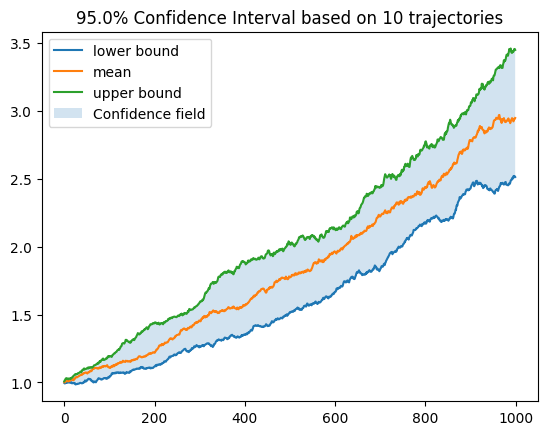

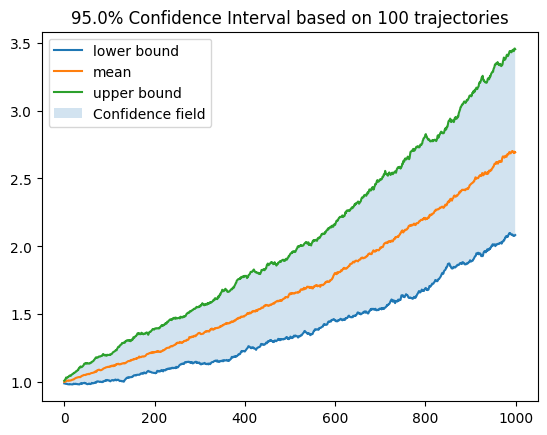

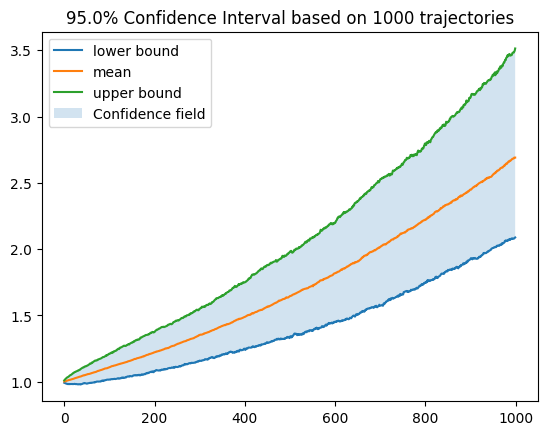

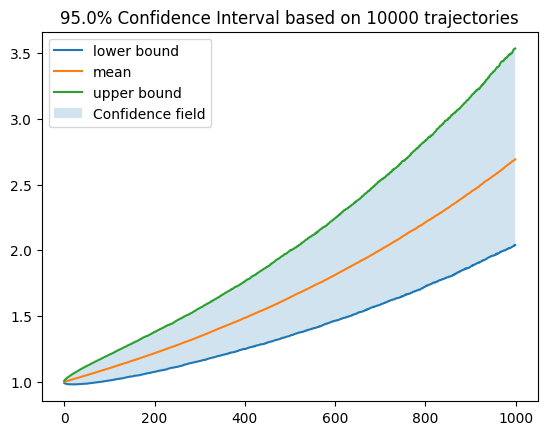

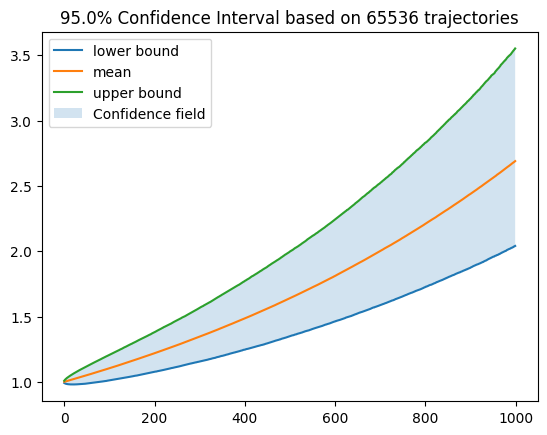

In [20]:
show_results(result[:10, :], dim, 0.05)
show_results(result[:100, :], dim, 0.05)
show_results(result[:1000, :], dim, 0.05)
show_results(result[:10_000, :], dim, 0.05)
show_results(result, dim, 0.05)

## Now let's multiply $\sigma$ by 10 :)

In [21]:
dim = 1
wiener_dim = 2
N = 1000
t_0 = 0.
T = 1.
threads, blocks = 512, 128
K = threads * blocks        # number of trajectories
start_point = np.array([[1.] for _ in range(dim)])
result = np.empty(shape=(K * dim, N))

@cuda.jit(device=True)
def drift_kernel(t, x, out):
    for i in range(x.shape[0]):
        out[i, 0] = 0.7**i * x[i, 0]


@cuda.jit(device=True)
def diffusion_kernel(t, x, out):
    for i in range(x.shape[0]):
        for j in range(wiener_dim):
            out[i, j] = (-1)**(i + j) * 1 * x[i, 0]

In [22]:
random_seed = cs.State(n=K, seed=777)   # change seed to obtain different result

kernel = WeakApprox(
    drift_kernel, diffusion_kernel,
    wiener_dim, dim,
    precision=cs.Precisions.float64,
    t_0=t_0, T=T, N=N, K=K, only_last=False,
).get_wrapped_kernel(state=random_seed)

kernel[blocks, threads](start_point, result)

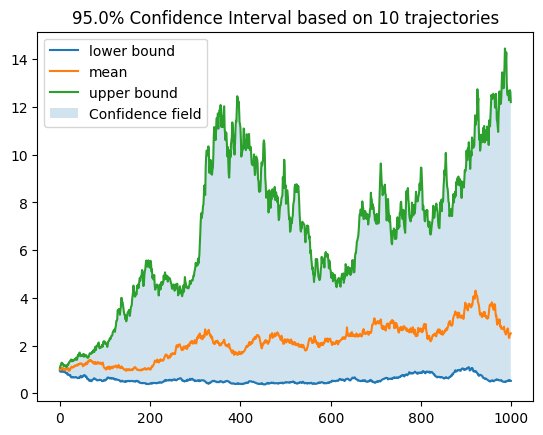

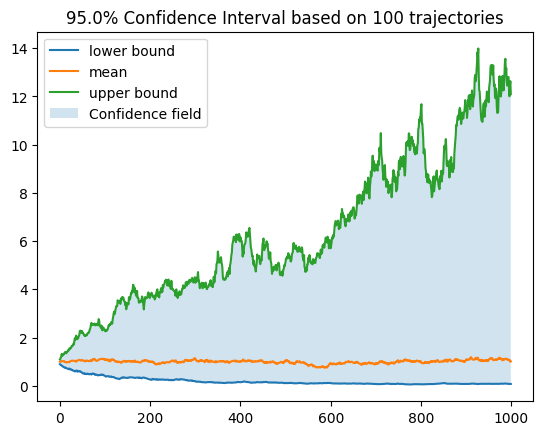

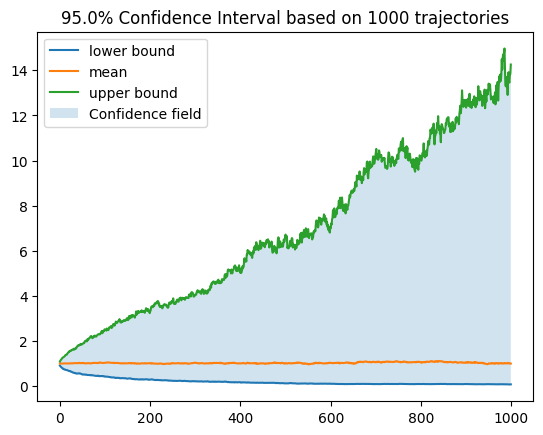

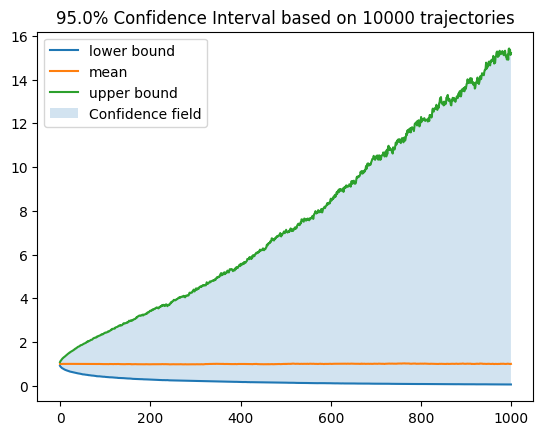

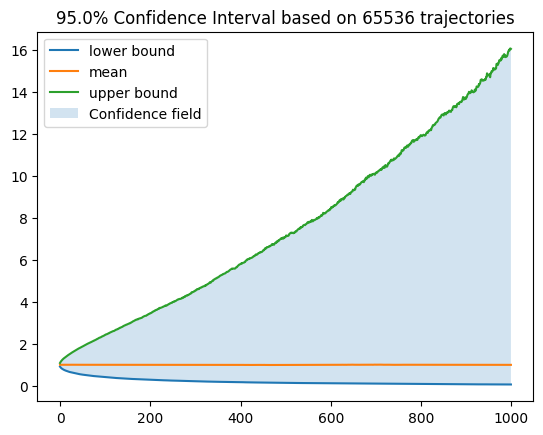

In [23]:
show_results(result[:10, :], dim, 0.05)
show_results(result[:100, :], dim, 0.05)
show_results(result[:1000, :], dim, 0.05)
show_results(result[:10_000, :], dim, 0.05)
show_results(result, dim, 0.05)

## What will happen if we change Wiener process dimensional?
### Please be careful with ram nad GPU memory!!!

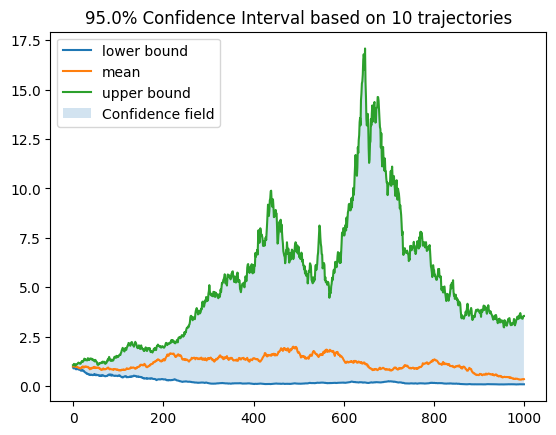

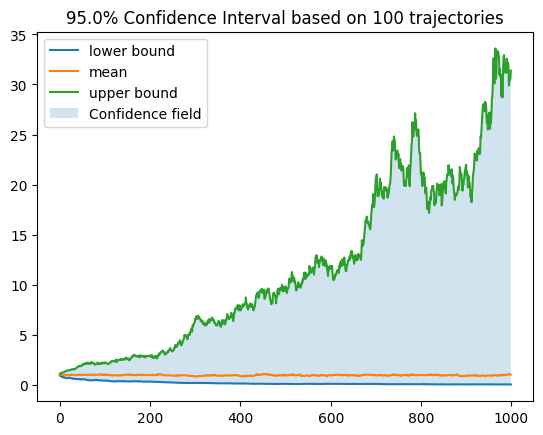

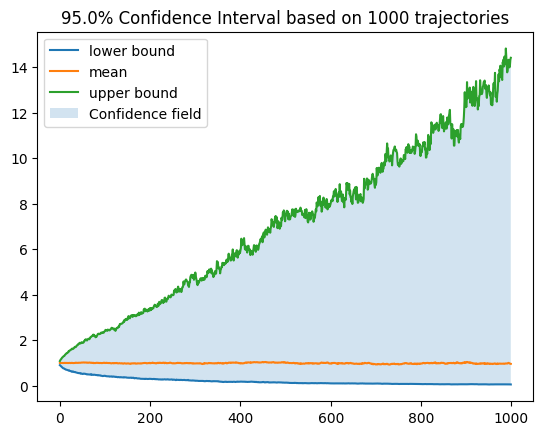

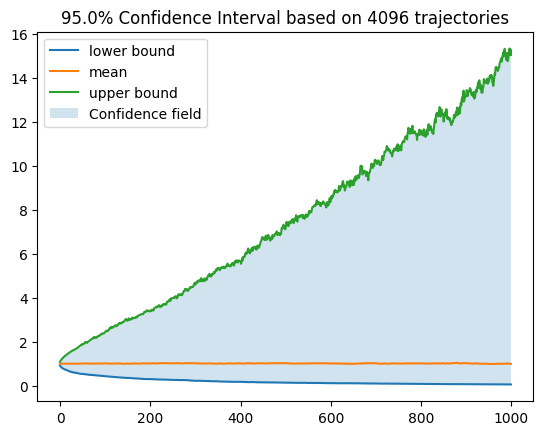

In [24]:
wiener_dim = 100
threads, blocks = 32, 128
K = threads * blocks        # number of trajectories
result = np.empty(shape=(K * dim, N))

random_seed = cs.State(n=K, seed=1234)   # change seed to obtain different result

kernel = WeakApprox(
    drift_kernel, diffusion_kernel,
    wiener_dim, dim,
    precision=cs.Precisions.float64,
    t_0=t_0, T=T, N=N, K=K, only_last=False,
).get_wrapped_kernel(state=random_seed)

kernel[blocks, threads](start_point, result)

show_results(result[:10, :], dim, 0.05)
show_results(result[:100, :], dim, 0.05)
show_results(result[:1000, :], dim, 0.05)
# show_results(result[:10_000, :], dim, 0.05)
show_results(result, dim, 0.05)